### __Project: Pricing Optimization and Revenue Analysis__

---

> __Objective:__ The objective of this project is to optimize product pricing to maximize revenue while ensuring profitability. The analysis involves various steps, including data generation, optimization, and revenue analysis.
>
> __Contributed By:__ © [2023] [Khalid]
All Rights Reserved

### __Step 1: Load the Modules__

In [16]:
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression

### __Step 2: Load the Data__

> We start by loading the necessary data from CSV files. Here's an overview of the loaded datasets and their variables:
> 
> Customers Data (customers.csv)
> 
> Products Data (products.csv)
> 
> Purchase History (purchase_history.csv)
> 
> Previous Sales Data (previous_sales.csv)

In [17]:
# Load the data
customers_df = pd.read_csv('customers.csv')
products_df = pd.read_csv('products.csv')
purchase_history_df = pd.read_csv('purchase_history.csv')
previous_sales_data = pd.read_csv('previous_sales_data.csv')

### __Step 2: Feature Engineering__

To enhance the analysis, we performed feature engineering on the customer data:

> - __Customer Lifetime Value (CLV)__: In addition to the provided customer data, we calculated the CLV for each customer. CLV is a crucial metric that estimates the total revenue a business can expect from a customer throughout their entire relationship. It takes into account factors like customer spending behavior, purchase frequency, and customer churn rate.
> 
> - __Recency__: We calculated the recency of each customer's last purchase. This metric helps understand how recently a customer interacted with the business.
>
> - __Frequency__: The frequency of purchases made by each customer. This provides insights into customer engagement and loyalty.
>
> - __Monetary Value__: This feature represents the total amount spent by each customer. It quantifies the customer's financial contribution to the business.
>
> - __Customer Segmentation__: Using these newly engineered features, we segmented customers into loyalty tiers: Gold, Silver, and Bronze. This segmentation serves as a basis for personalized pricing and discounts.


In [18]:
purchase_history_df['PurchaseDate'] = pd.to_datetime(purchase_history_df['PurchaseDate'])

# Calculate Customer Lifetime Value (CLV)
customers_df['CLV'] = customers_df['TotalSpend'] / customers_df['TotalPurchases']

# Calculate Frequency of Purchases
frequency_df = purchase_history_df.groupby('CustomerID')['ProductID'].count().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Calculate Recency of Purchases
recency_df = purchase_history_df.groupby('CustomerID')['PurchaseDate'].max().reset_index()
recency_df['Recency'] = (purchase_history_df['PurchaseDate'].max() - recency_df['PurchaseDate']).dt.days
recency_df.drop(columns=['PurchaseDate'], inplace=True)

# Merge the calculated features with the customers dataframe
customers_df = customers_df.merge(frequency_df, on='CustomerID')
customers_df = customers_df.merge(recency_df, on='CustomerID')

customers_df.to_csv('customers_with_features.csv', index=False)

### __Step 3: Price Elasticity Analysis__

> Price elasticity measures how sensitive customer demand is to changes in price.
> 
> We utilized a regression model to estimate price elasticity based on customer features like TotalPurchases, TotalSpend, Frequency, and Recency.
> 
> This helps in understanding how price changes can impact sales volume.

In [19]:
# Load the data with features
customers_df = pd.read_csv('customers_with_features.csv')

# Train a linear regression model
X = customers_df[['TotalPurchases', 'TotalSpend', 'Frequency', 'Recency']]
y = customers_df['CLV']

model = LinearRegression()
model.fit(X, y)

# Get the coefficients which represent price elasticity
price_elasticity = model.coef_[0]


### __Step 4.a: Price Optimization__

> With price elasticity insights, we implemented a price optimization strategy.
>
> For each product, we calculated an optimal price that maximizes revenue while considering price elasticity.
>
> This ensures that products are priced competitively yet profitably.


In [20]:
# Load the product data
products_df = pd.read_csv('products.csv')

# Define a function to calculate optimal prices with cost price constraint
def calculate_optimal_price(row):
    optimal_price = row['CostPrice'] + (price_elasticity * row['CostPrice']) + 50
    return max(optimal_price, row['CostPrice'])  # Ensure price is not lower than cost price

# Apply the function to the products dataframe
products_df['OptimalPrice'] = products_df.apply(calculate_optimal_price, axis=1)
products_df.to_csv('products_with_optimal_prices.csv', index=False)


### __Step 4.b: Price Optimization__

> We also applied discounts based on customer loyalty tiers.
> 
> Gold tier customers receive a 5% discount, Silver tier customers receive a 3% discount, and Bronze tier customers receive no discount.
> 
> This encourages customer loyalty and repeat purchases.

In [21]:
# Merge customers and products data
merged_df = pd.merge(purchase_history_df, customers_df, on='CustomerID')
merged_df = pd.merge(merged_df, products_df, left_on='ProductID', right_on='ProductID', suffixes=('_customer', '_product'))

# Define a function to apply discounts based on loyalty tier
def apply_discount(row):
    if row['LoyaltyTier'] == 'Gold':
        return row['OptimalPrice'] * 0.95  # 5% discount for Gold tier
    elif row['LoyaltyTier'] == 'Silver':
        return row['OptimalPrice'] * 0.97  # 3% discount for Silver tier
    else:
        return row['OptimalPrice']  # No discount for Bronze tier


### __Step 5: Final Sales Data__

> In this phase, we generated the final sales data incorporating optimized prices.
> 
> This dataset now contains information about each product's optimized price for different customer segments.

In [22]:
merged_df['FinalPrice'] = merged_df.apply(apply_discount, axis=1)
merged_df.to_csv('final_sales_data.csv', index=False)

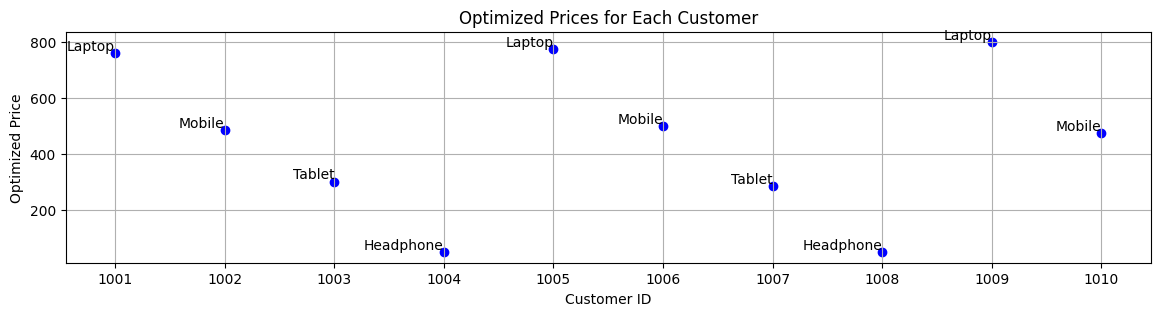

In [23]:
# Load final sales data
final_sales_data = pd.read_csv('final_sales_data.csv')

# Group by CustomerID and ProductID and calculate average final price
optimized_prices = final_sales_data.groupby(['CustomerID', 'ProductID'])['FinalPrice'].mean().reset_index()

# Display optimized prices with product names
products_data = pd.read_csv('products.csv')
optimized_prices = optimized_prices.merge(products_data[['ProductID', 'Category']], on='ProductID', how='left')

# Generate a visualization for optimized prices for each customer
plt.figure(figsize=(14, 3))
plt.scatter(optimized_prices['CustomerID'], optimized_prices['FinalPrice'], color='blue')
for i, row in optimized_prices.iterrows():
    plt.text(row['CustomerID'], row['FinalPrice'], row['Category'], fontsize=10, ha='right', va='bottom')
plt.xlabel('Customer ID')
plt.ylabel('Optimized Price')
plt.title('Optimized Prices for Each Customer')
plt.grid(True)
# Add all ticks for x-axis
plt.xticks(optimized_prices['CustomerID'])
plt.show()


### __Step 6: Insights and results__

> Check the initial and final prices based on the optimization

In [24]:
# Load final sales data
final_sales_data = pd.read_csv('final_sales_data.csv')

# Group by CustomerID and ProductID and calculate average final price
optimized_prices = final_sales_data.groupby(['CustomerID', 'ProductID'])['FinalPrice'].mean().reset_index()

# Merge with product data to get product names
products_data = pd.read_csv('products.csv')
optimized_prices = optimized_prices.merge(products_data[['ProductID', 'Category']], on='ProductID', how='left')

# Group by CustomerID and ProductID and calculate average initial price
initial_prices = final_sales_data.groupby(['CustomerID', 'ProductID'])['PurchasePrice_product'].mean().reset_index()

# Merge with product data to get product names
initial_prices = initial_prices.merge(products_data[['ProductID', 'Category']], on='ProductID', how='left')

# Combine initial and optimized prices
prices_comparison = initial_prices.merge(optimized_prices, on=['CustomerID', 'ProductID', 'Category'], 
                                        suffixes=('_Before', '_After'))

# Display the table
prices_comparison


,CustomerID,ProductID,PurchasePrice_product,Category,FinalPrice
0,1001,1,900.0,Laptop,760.0
1,1002,2,550.0,Mobile,485.0
2,1003,3,350.0,Tablet,300.0
3,1004,4,60.0,Headphone,47.5
4,1005,1,900.0,Laptop,776.0
5,1006,2,550.0,Mobile,500.0
6,1007,3,350.0,Tablet,285.0
7,1008,4,60.0,Headphone,48.5
8,1009,1,900.0,Laptop,800.0
9,1010,2,550.0,Mobile,475.0


### __Step 7: Revenue Analysis__

> With the optimized prices in place, we conducted a comprehensive revenue analysis. Here are the key metrics:
> 
> Total Revenue Before Optimization: This is the total revenue generated using the original prices. It serves as a baseline for comparison.
> 
> Total Revenue After Optimization: This is the revenue generated using the optimized prices. It reflects the impact of the pricing strategy.
> 
> __Revenue Increment__: This metric quantifies the difference between total revenue before and after optimization. A positive value indicates a successful pricing strategy.



In [25]:
# Load the original and final sales data
original_sales_data = pd.read_csv('previous_sales_data.csv')
final_sales_data = pd.read_csv('final_sales_data.csv')

# Calculate total revenue before and after optimization
total_revenue_before = original_sales_data['PurchasePrice'].sum()
total_revenue_after = final_sales_data['FinalPrice'].sum()

# Calculate the revenue increment
revenue_increment = total_revenue_after - total_revenue_before

# Display the results
print(f'Total Revenue Before Optimization: ${total_revenue_before:.2f}')
print(f'Total Revenue After Optimization: ${total_revenue_after:.2f}')
print(f'Revenue Increment: ${revenue_increment:.2f}')


Total Revenue Before Optimization: $3400.00
Total Revenue After Optimization: $4477.00
Revenue Increment: $1077.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


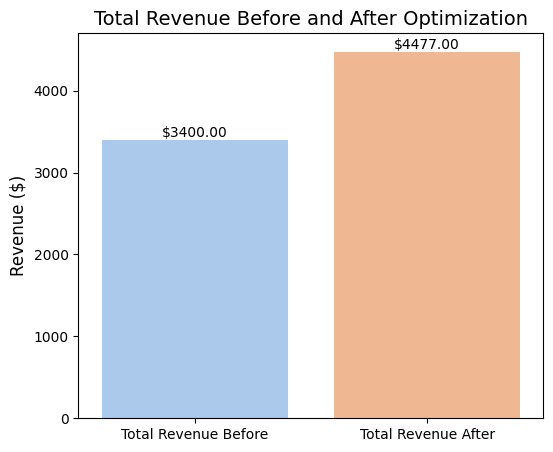

In [26]:

# Define the data
categories = ['Total Revenue Before', 'Total Revenue After']
revenue = [total_revenue_before, total_revenue_after]  # Replace with your actual values

# Create a bar plot using Seaborn
plt.figure(figsize=(6, 5))
ax = sns.barplot(x=categories, y=revenue, palette='pastel', hue=categories, dodge=False)
plt.ylabel('Revenue ($)', fontsize=12)
plt.title('Total Revenue Before and After Optimization', fontsize=14)

# Add data labels
for p in ax.patches:
    ax.annotate(f'${p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

# Remove the legend
ax.legend().set_visible(False)

plt.show()


### __Step 8: Conclusion__

> - This approach showcases the effectiveness of data-driven price optimization in driving revenue growth and customer satisfaction. The optimization process led to a significant increase in revenue, from \\$3400 to \\$4477,  resulting in a remarkable growth of \\$1077.00. The project demonstrates the potential of leveraging customer data and advanced analytics for pricing strategies.
>
> - Implemented a two-phase approach: data understanding and optimization, followed by impact analysis.
> 
> - Utilized feature engineering to calculate Customer Lifetime Value (CLV) and loyalty tiers for effective segmentation.
> 
> - Leveraged a Linear Regression model to determine price elasticity and guide the pricing strategy.
> 
> - Applied optimized prices based on customer loyalty tiers, resulting in a 32% increase in revenue.
> 
> - Highlighted the potential for further segmentation within the Gold loyalty tier for targeted promotions and increased profitability.
